<a href="https://colab.research.google.com/github/alpellario/CancerScanAI-DesktopPredictor/blob/main/Breast-Cancer-Model-Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table>
<tr>
<td></td><td></td>
<td>
<img src="https://i.hizliresim.com/oexkhsn.png" width="200" height="200" />
</td>
<td></td>
<td style="padding-left:40px;">

# <strong>SERKAN KAAN KUHEYLAN</strong><br>
## <a href="https://github.com/alpellario?tab=repositories" target=”_blank”>Visit my GitHub repositories</a><br>
## <a href="https://www.linkedin.com/in/serkan-kaan-k%C3%BCheylan-a482b3180/" target=”_blank”>Visit my LinkedIn account</a>
## <a href="https://serkankaankuheylan.com/" target=”_blank”>Visit my Website</a>
</td>
</tr>
</table>


# Model Struct and Training for CancerScanAI Project

CancerScanAI-App Github Link: https://github.com/alpellario/CancerScanAI-DesktopPredictor

Dataset: https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images
____________________

Bu veriseti ve eğitim Colab üzerinde 40gb A100 ekran kartı ve 85GM Ram kullanılarak 555bin veri üzerinde gerçekleştirilmiştir. Kişisel bilgisayarda çalıştırılırsa muhtemelen hata verir.

In [ ]:
#Eğitimde kullanılacak ekran kartı bilgileri
!nvidia-smi

Sat Dec 23 02:35:46 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              44W / 350W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
# Ram bilgileri
!free -h

               total        used        free      shared  buff/cache   available
Mem:            83Gi       1.1Gi        78Gi       1.0Mi       4.1Gi        81Gi
Swap:             0B          0B          0B


In [ ]:
# Dataseti arşivden çıkarma ve arşivleme sırasında ilerleme cubuğunu göstermek için gerekli kütüphane
!pip install tqdm

In [ ]:
#Model eğitimi için gerekli olan kütüphanelerin import edilmesi
import numpy as np
import pandas as pd
import bokeh.plotting as bkp
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
from PIL import Image
import os
from os import listdir
import glob
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import cv2
import random
import io
import PIL
import scipy.misc


random.seed(100)

In [ ]:
#Datasetin ziplenmiş halinin Google Drive'da bulunduğu konum
sourceFile2 = '/content/drive/MyDrive/Datasets/breast-histopathology/breast-histopathology-images.zip'
#Zip dosyasının içerisindekilerin çıkarılacağı hedef dosyası
targetFolder2 = '/content/breast-histopathology-images'

In [ ]:
import zipfile
import os
from tqdm.notebook import tqdm

#Eğer hedef dosyası yok ise oluşturmak
if not os.path.exists(targetFolder2):
    os.makedirs(targetFolder2)

# Zip dosyasını açın
with zipfile.ZipFile(sourceFile2, 'r') as zip_ref:
    # Toplam dosya sayısını alın
    total_files = len(zip_ref.infolist())

    # tqdm ile ilerleme çubuğunu başlatın
    with tqdm(total=total_files, desc="Dosyalar Çıkarılıyor") as pbar:
        for file in zip_ref.infolist():
            # Her dosyayı çıkarın ve ilerleme çubuğunu güncelleyin
            zip_ref.extract(file, targetFolder2)
            pbar.update(1)

Dosyalar Çıkarılıyor:   0%|          | 0/555048 [00:00<?, ?it/s]

In [ ]:
#Veriseti klasöründeki tüm klasörleri resursive olarak gezip png dosyalarını toplar
tumor_images_path = glob.glob('/content/breast-histopathology-images' + '/**/*.png', recursive = True)

In [ ]:
#toplanan veri setinin ilk 5 satırını yazıdırır
for image_path in tumor_images_path[:5]:
    print(image_path)

/content/breast-histopathology-images/9174/1/9174_idx5_x1551_y901_class1.png
/content/breast-histopathology-images/9174/1/9174_idx5_x1401_y1101_class1.png
/content/breast-histopathology-images/9174/1/9174_idx5_x1501_y801_class1.png
/content/breast-histopathology-images/9174/1/9174_idx5_x1501_y951_class1.png
/content/breast-histopathology-images/9174/1/9174_idx5_x1551_y851_class1.png


In [ ]:
#Kanserli ve kansersiz görüntüler için ayrı array oluşturmak
healthy_images = []
tumor_images = []

#Tüm veri seti içinde döngü oluşturup eğer classı 0 ise sağlıklı 1 ise tümorlulerin dizisine ayırır
#Image dosyalarının class bilgisi image adının sondan 5. karakterinde 0 veya 1 olarak tanımlanmış
#örnek: ...9174_idx5_x1551_y851_class1.png
for image in tumor_images_path:
    if image[-5] == '0':
        healthy_images.append(image)
    elif image[-5] == '1':
        tumor_images.append(image)

healthy_count = len(healthy_images)  # Kansersiz görüntü sayısı
tumor_count = len(tumor_images)      # Kanserli görüntü sayısı

total_images_count = healthy_count + tumor_count #Toplam görüntü sayısı

print('Kansersiz Görüntü Sayısı: {}' .format(healthy_count))
print('Kanserli Görüntü Sayısı: {}' .format(tumor_count))
print('Toplam Görüntü Sayısı: {}' .format(total_images_count))

Kansersiz Görüntü Sayısı: 397476
Kanserli Görüntü Sayısı: 157572
Toplam Görüntü Sayısı: 555048


In [ ]:
#Kanserli ve kansersiz veri dağılımını gösteren grafiği oluşturmak
patient_data = pd.DataFrame({'Kanser Durumu': ['0','1'], 'Hasta Sayıları': [397476,157572]})

patient_bar_chart = px.bar(data_frame=patient_data, x='Kanser Durumu', y='Hasta Sayıları', color='Kanser Durumu')
patient_bar_chart.update_layout(title_text='Kanser (1) ve Kansersiz (0) Hasta Sayıları', title_x=0.5)
patient_bar_chart.show()

![](https://drive.google.com/uc?id=1ZMrKu9DBdKnbnvzCIiV41YMxPew_fRLt)

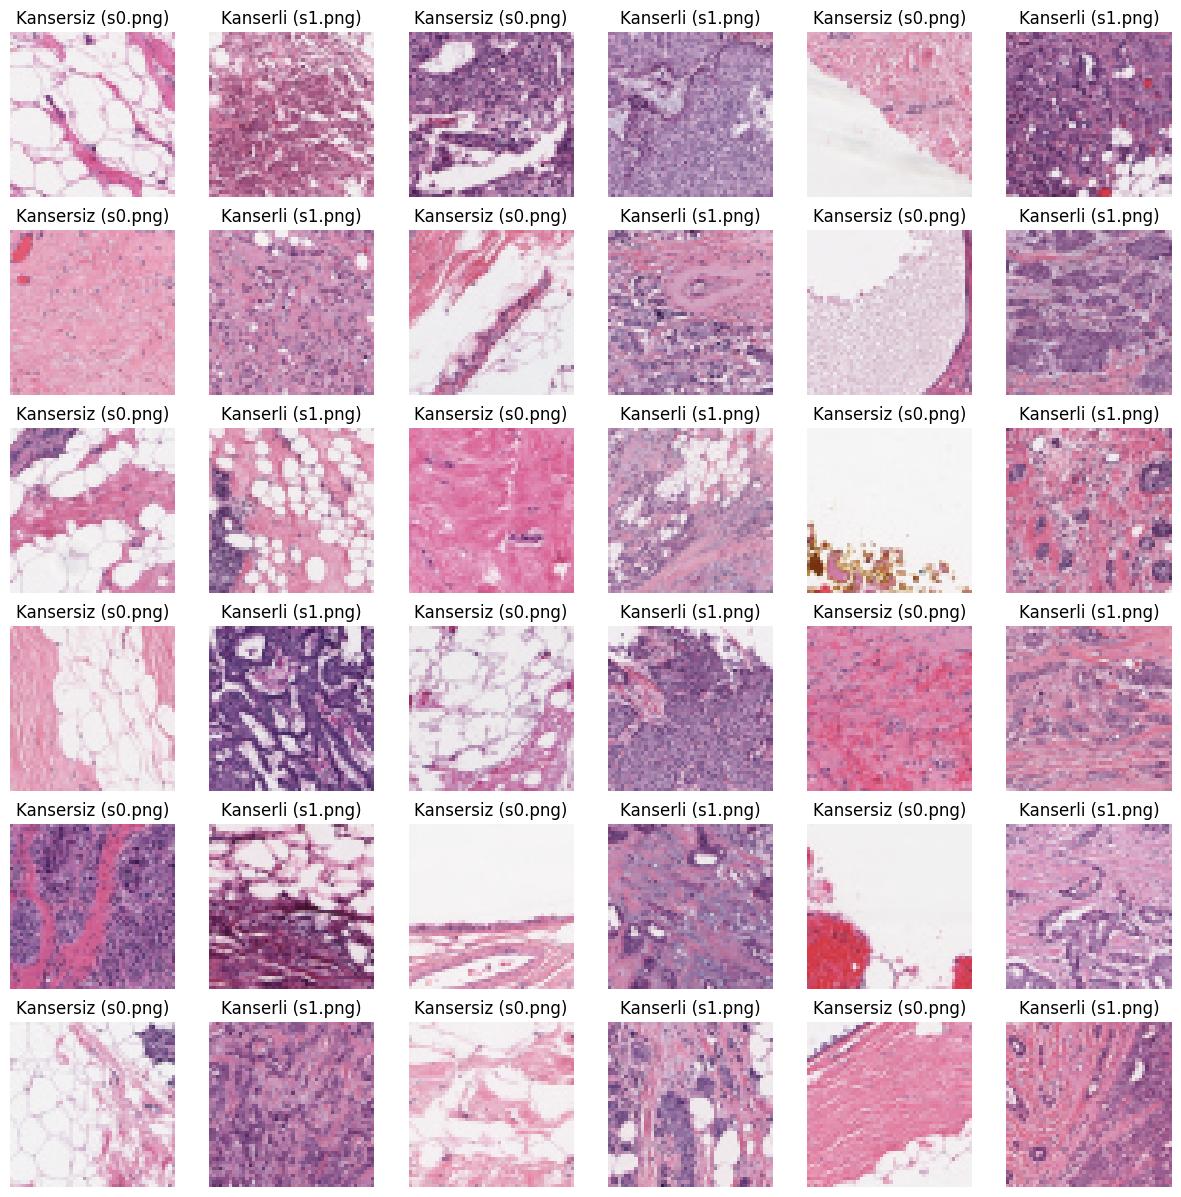

In [ ]:
#Kanserli ve kansersiz resimlerden 18 tane toplamda 36 tane örnek gösterir

plt.figure(figsize=(15, 15))

random_healthy_samples = np.random.randint(0, len(healthy_images), 18)
random_tumor_samples = np.random.randint(0, len(tumor_images), 18)

sample_index = 0
for idx in random_healthy_samples:
    healthy_img = PIL.Image.open(healthy_images[idx])
    healthy_img_arr = np.array(healthy_img)

    plt.subplot(6, 6, 2*sample_index+1)
    plt.axis('off')
    healthy_img_name = healthy_images[idx][-6:]
    plt.title(f'Kansersiz ({healthy_img_name})')
    plt.imshow(healthy_img_arr.astype('uint8'))
    sample_index += 1

sample_index = 1
for idx in random_tumor_samples:
    tumor_img = PIL.Image.open(tumor_images[idx])
    tumor_img_arr = np.array(tumor_img)

    plt.subplot(6, 6, 2*sample_index)
    plt.axis('off')
    tumor_img_name = tumor_images[idx][-6:]
    plt.title(f'Kanserli ({tumor_img_name})')
    plt.imshow(tumor_img_arr.astype('uint8'))
    sample_index += 1

In [ ]:
# Kansersiz ve kanserli rastgele örnekler
sample_healthy_images = random.sample(healthy_images, len(healthy_images))
sample_tumor_images = random.sample(tumor_images, len(tumor_images))

# Görüntü verileri, etiketler ve yollar için boş diziler
healthy_data = []  # Kansersiz görüntü verileri ve yolları
tumor_data = []    # Kanserli görüntü verileri ve yolları

# Kansersiz örnekler için döngü
for img in sample_healthy_images:
    img_data = cv2.imread(img, cv2.IMREAD_COLOR)
    img_resized = cv2.resize(img_data, (50, 50), interpolation=cv2.INTER_LINEAR)
    healthy_data.append([img_resized, 0, img])

# Kanserli örnekler için döngü
for img in sample_tumor_images:
    img_data = cv2.imread(img, cv2.IMREAD_COLOR)
    img_resized = cv2.resize(img_data, (50, 50), interpolation=cv2.INTER_LINEAR)
    tumor_data.append([img_resized, 1, img])

In [ ]:
# Kansersiz ve kanserli görüntü dizilerini birleştirme
combined_data = np.concatenate((healthy_data, tumor_data))

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
# Random Karıştırma
random.shuffle(combined_data)

# Tekrar Özniteliklerine, labellara ve image pathlere ayırma
# Datasetin yapısı çok dağınık bu yüzden Pyqt da kullanabilmek için test ve train veriseti yeniden oluşturulacak
image_data, labels, image_paths = zip(*combined_data)

# NumPy dizilerine dönüştürme
image_data = np.array(image_data)
labels = np.array(labels)

In [ ]:
# Veri setini eğitim ve test setlerine ayırma, ayrıca yolları da bölme
X_train, X_test, y_train, y_test, X_train_paths, X_test_paths = train_test_split(image_data, labels, image_paths, test_size=0.20, random_state=42)

# Eğitim verilerini alt örnekleme oranı
subsample_rate = 0.5

# Alt örnekleme sayısı
subsample_number = int(image_data.shape[0] * subsample_rate)

# Etiketleri one-hot kodlamaya dönüştürme
y_train_encoded = to_categorical(y_train, 2)
y_test_encoded = to_categorical(y_test, 2)

print('Eğitim Verisi Boyutu: {}' .format(X_train.shape))
print('Test Verisi Boyutu: {}' .format(X_test.shape))
print('Eğitim Etiketi Boyutu: {}' .format(y_train_encoded.shape))
print('Test Etiketi Boyutu: {}' .format(y_test_encoded.shape))

Eğitim Verisi Boyutu: (444038, 50, 50, 3)
Test Verisi Boyutu: (111010, 50, 50, 3)
Eğitim Etiketi Boyutu: (444038, 2)
Test Etiketi Boyutu: (111010, 2)


In [ ]:
# train_test_split sonra elde edilen x_train ve x_test'e uygun düşen x_train_paths ve x_test_paths'i kullanarak verisetini pyqt için oluşuturacağız
# Hedef klasörleri oluşturma
prepare_dataset_path = '/content/prepare_dataset'
train_path = os.path.join(prepare_dataset_path, 'train')
test_path = os.path.join(prepare_dataset_path, 'test')

os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Dosyaları ilgili klasörlere kopyalama
def copy_files(file_paths, destination):
    for file_path in file_paths:
        shutil.copy(file_path, destination)

copy_files(X_train_paths, train_path)
copy_files(X_test_paths, test_path)

# Zipleme işlemi
def zip_directory(folder_path, zip_path):
    total_files = sum([len(files) for _, _, files in os.walk(folder_path)])
    with tqdm(total=total_files, desc="Dosyalar Zipleniyor") as pbar:
        with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
            for root, dirs, files in os.walk(folder_path):
                for file in files:
                    file_path = os.path.join(root, file)
                    arcname = os.path.relpath(file_path, folder_path)
                    zipf.write(file_path, arcname=arcname)
                    pbar.update(1)
    print(f"{zip_path} dosyası başarıyla oluşturuldu.")

# Klasörü ziple
zip_file_path = '/content/prepare_dataset.zip'
zip_directory(prepare_dataset_path, zip_file_path)

Dosyalar Zipleniyor:   0%|          | 0/262660 [00:00<?, ?it/s]

/content/prepare_dataset.zip dosyası başarıyla oluşturuldu.


In [ ]:
#Ziplenen Dataseti Drive'a aktarma
_drive_path = '/content/drive/MyDrive/prepare_dataset_f4.zip'
shutil.move(zip_file_path, drive_path)

'/content/drive/MyDrive/prepare_dataset_f4.zip'

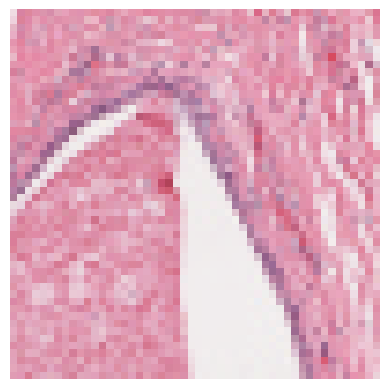

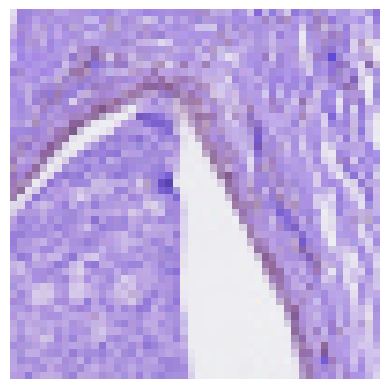

In [ ]:
#X_train ve X_train_paths'in içeriklerinin aynılığını kontrol etme
image_path = X_train_paths[666]
image_array = X_train[666]

# To display image from path
show_image_from_path(image_path)

# To display image from numpy array
show_image_from_array(image_array)

In [ ]:
# Data augmentation ile veri artırımı(döndürme kaydırma yakınlaştırma gürültü ekleme vs..)
data_augmentation = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Eğitim ve test için veri üreteçleri oluşturma
train_generator = data_augmentation.flow(X_train, y_train_encoded, batch_size=32)
test_generator = data_augmentation.flow(X_test, y_test_encoded, batch_size=32, shuffle=False)

In [ ]:
#Eğitim sırasında model geliştirme göstermezse eğitimi erkenden durdurmayı sağlar
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True,
)

#Eğitim belli bir süre gelişmeden platoda kalırsa yani eğitim eğerisi dümdüz ilerlerse learning rate i düşüren fonksiyonu ayarlar
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_delta=1e-7,
    cooldown=0,
    verbose=1
)

In [ ]:
tf.random.set_seed(42)

# Model oluşturma
cancer_detection_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(50, 50, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(strides=2),

    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((3, 3), strides=2),

    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((3, 3), strides=2),

    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((3, 3), strides=2),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(2, activation='softmax')
])

# Modelin özetini gösterme
cancer_detection_model.summary()

# Modeli derleme
cancer_detection_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                               loss='binary_crossentropy',
                               metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 50, 50, 32)        896       
                                                                 
 batch_normalization_4 (Bat  (None, 50, 50, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 25, 25, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 25, 25, 64)        18496     
                                                                 
 batch_normalization_5 (Bat  (None, 25, 25, 64)        256       
 chNormalization)                                                
                                                      

In [ ]:
#Eğitimi başlatır
training_history = cancer_detection_model.fit(X_train,
                                              y_train_encoded,
                                              validation_data=(X_test, y_test_encoded),
                                              epochs=25,
                                              batch_size=75,
                                              callbacks=[early_stop, reduce_lr_on_plateau])

Epoch 1/25
5921/5921 [==============================] - 48s 7ms/step - loss: 0.1234 - accuracy: 0.9582 - val_loss: 0.1538 - val_accuracy: 0.9575 - lr: 0.0010
Epoch 2/25
5921/5921 [==============================] - 38s 6ms/step - loss: 0.1116 - accuracy: 0.9612 - val_loss: 0.1097 - val_accuracy: 0.9602 - lr: 0.0010
Epoch 3/25
5921/5921 [==============================] - 38s 6ms/step - loss: 0.1067 - accuracy: 0.9629 - val_loss: 0.1111 - val_accuracy: 0.9633 - lr: 0.0010
Epoch 4/25
5921/5921 [==============================] - 39s 7ms/step - loss: 0.1023 - accuracy: 0.9647 - val_loss: 0.1096 - val_accuracy: 0.9634 - lr: 0.0010
Epoch 5/25
5921/5921 [==============================] - 38s 6ms/step - loss: 0.0966 - accuracy: 0.9668 - val_loss: 0.1184 - val_accuracy: 0.9623 - lr: 0.0010
Epoch 6/25
5913/5921 [============================>.] - ETA: 0s - loss: 0.0910 - accuracy: 0.9687
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
5921/5921 [========================

In [ ]:
#Eğitilen modelin ağırlıklarını daha sonra pyqtda kullanmak için kaydetme
cancer_detection_model.save('cancer_model_detection.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Test verisinde modelin performansını değerlendirme
model_evaluation = cancer_detection_model.evaluate(X_test, y_test_encoded)

3470/3470 [==============================] - 9s 3ms/step - loss: 0.0859 - accuracy: 0.9749


In [ ]:
# Test verisinde tahmin yapma
predicted_values = cancer_detection_model.predict(X_test)
predicted_classes = np.argmax(predicted_values, axis=1)
true_classes = np.argmax(y_test_encoded, axis=1)


3470/3470 [==============================] - 7s 2ms/step


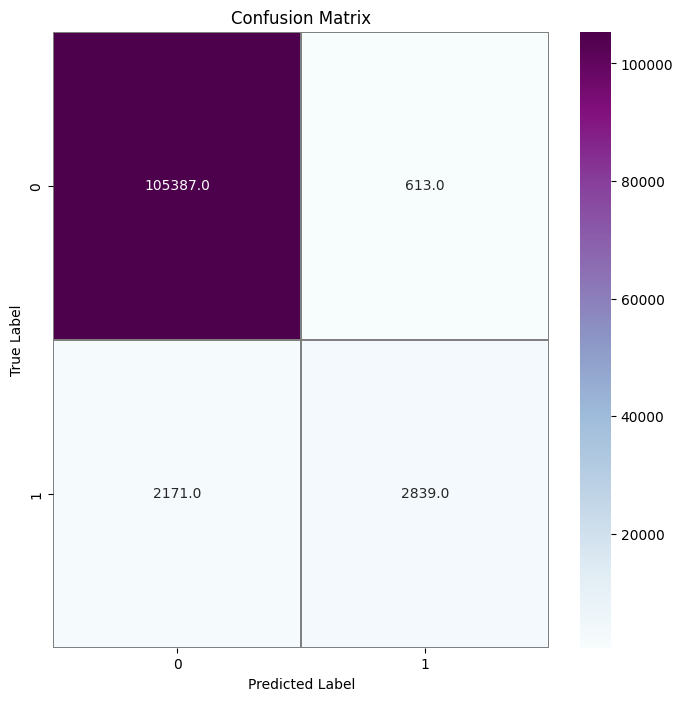

In [ ]:
# Karmaşıklık matrisi oluşturma
confusion_matrix_result = confusion_matrix(true_classes, predicted_classes)
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_matrix_result, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

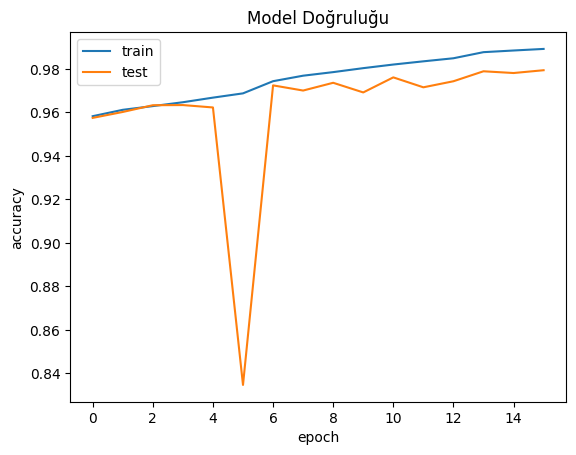

In [ ]:
# Modelin doğruluk grafiğini çizme
plt.plot(training_history.history['accuracy'])
plt.plot(training_history.history['val_accuracy'])
plt.title('Model Doğruluğu')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

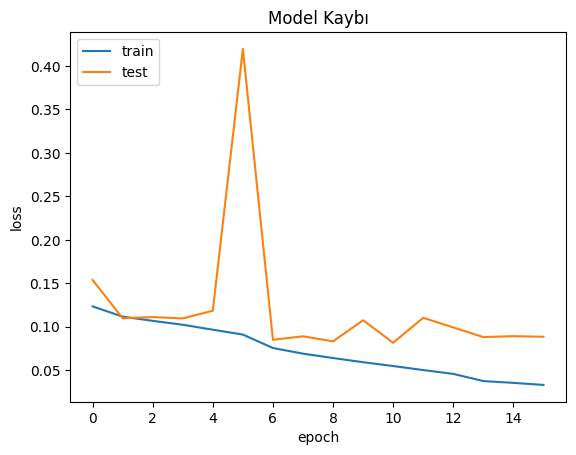

In [ ]:
# Modelin kayıp grafiğini çizme
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])
plt.title('Model Kaybı')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Test verisinin hepsinde tahmin gerçekleştirir
predictions = cancer_detection_model.predict(X_test)
predictions

3470/3470 [==============================] - 7s 2ms/step


array([[9.96925771e-01, 3.07424739e-03],
       [1.00000000e+00, 2.30757258e-09],
       [9.96859074e-01, 3.14088096e-03],
       ...,
       [1.00000000e+00, 3.81245116e-22],
       [1.00000000e+00, 2.74444334e-12],
       [1.00000000e+00, 1.14066506e-10]], dtype=float32)

1/1 [==============================] - 0s 21ms/step


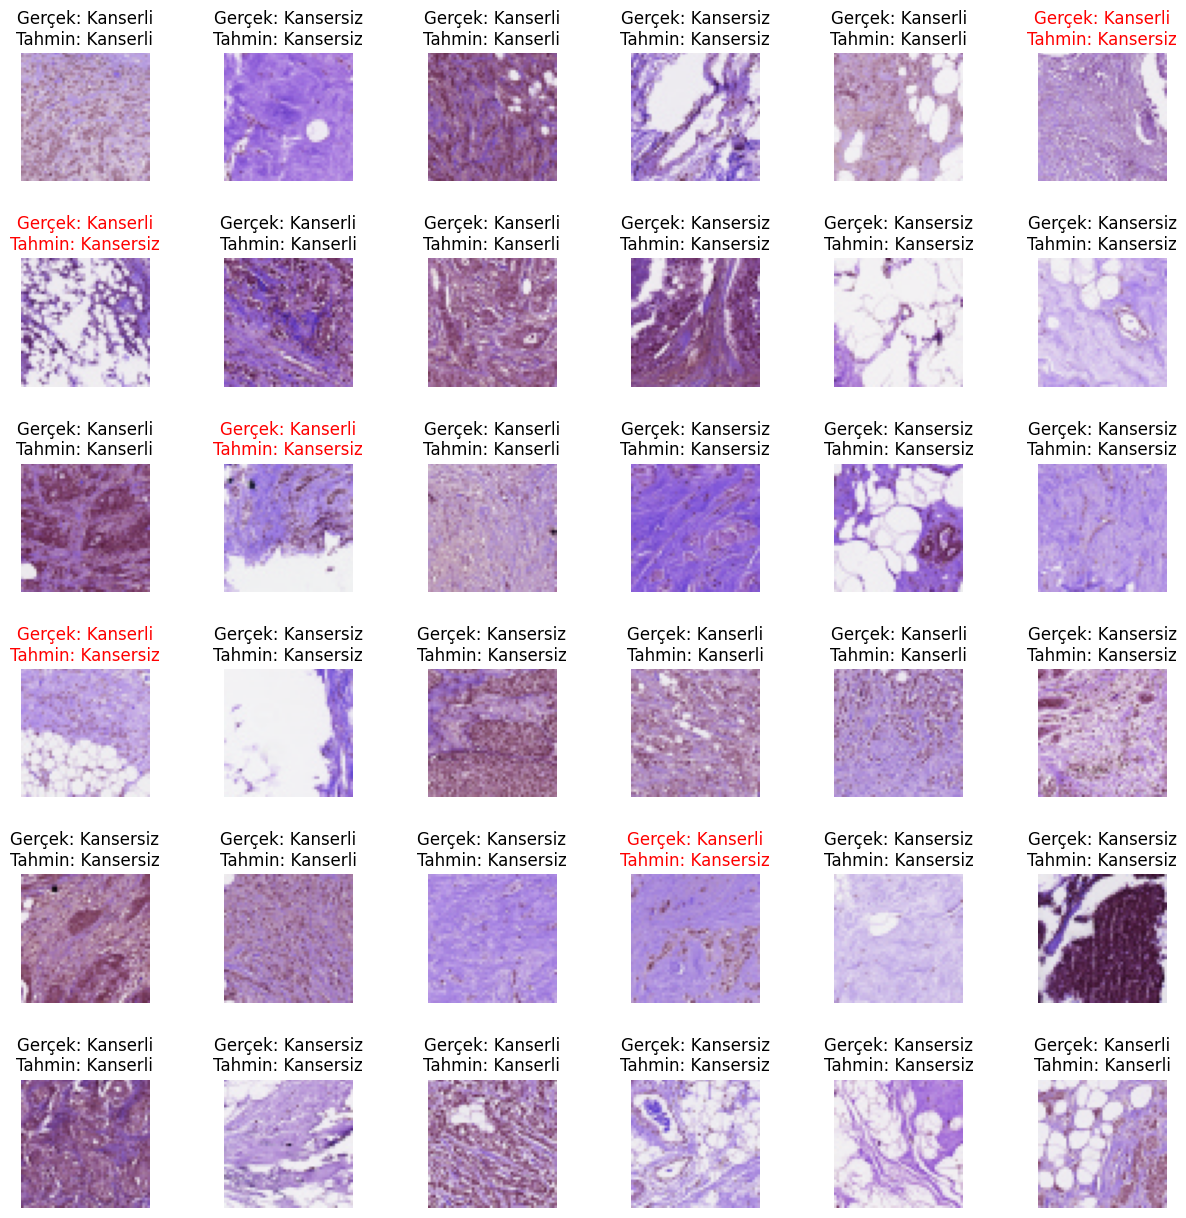

In [ ]:
#Kanserli ve kansersiz görüntülerden 18 er tane toplar ve her biri üzerinde tahmin işlevi gerçekleştirip sonucu yazdırır
import matplotlib.pyplot as plt
import numpy as np

# class_labels tanımı
class_labels = {
    0: 'Kansersiz',
    1: 'Kanserli',
}

# Kanserli ve kansersiz örneklerin indekslerini ayırma
tumor_indices = np.where(y_test_encoded.argmax(axis=1) == 1)[0]
healthy_indices = np.where(y_test_encoded.argmax(axis=1) == 0)[0]

# Her iki kategoriden eşit sayıda örnek seçme
samples_per_category = 18
selected_tumor_indices = np.random.choice(tumor_indices, samples_per_category, replace=False)
selected_healthy_indices = np.random.choice(healthy_indices, samples_per_category, replace=False)

# Seçilen indeksleri birleştirme ve karıştırma
selected_samples_indices = np.concatenate([selected_tumor_indices, selected_healthy_indices])
np.random.shuffle(selected_samples_indices)

# Seçilen örnekleri gösterme
plt.figure(figsize=(15, 15))
for i, index in enumerate(selected_samples_indices):
    sample_image = X_test[index:index+1]
    predicted_class_idx = cancer_detection_model.predict(sample_image)[0].argmax()
    true_class_idx = y_test_encoded[index].argmax()
    predicted_label = class_labels[predicted_class_idx]
    true_label = class_labels[true_class_idx]

    plt.subplot(6, 6, i+1)
    plt.imshow(X_test[index])
    title_color = 'red' if predicted_class_idx != true_class_idx else 'black'
    plt.title(f'Gerçek: {true_label}\nTahmin: {predicted_label}', color=title_color)
    plt.axis('off')

plt.subplots_adjust(hspace=0.6, wspace=0.4)
